In [1]:
# !git config --global user.name "LanceM28" 
# !git config --global git config --global user.email "lmoreau@terpmail.umd.edu"

In [ ]:
from pathlib import Path
from astropy.table import Table

# fetches up files from directory and saves them in a dictionary 
def searcher(start_path, dirname):
    # Start from a high-level but not-too-huge root directory
    search_root = Path(str(start_path))

    # Recursively look for the directory
    matches = list(search_root.rglob(str(dirname)))

    if matches:
        jwst_dir = matches[0]  # Use the first match (or loop over all if multiple found)
        print(f"Found directory: {jwst_dir}")

        # List all files in its subdirectories
        all_files = [f for f in jwst_dir.glob("**/*") if f.is_file()]
        print(f"Found {len(all_files)} files:")
        disp_files = [str(f) for f in all_files if f.suffix == ".fits"]
        file_dict = {}
        for f in disp_files:
            df = Table.read(f)
            # dex = (f.split("/")[-1]).split("_")[2]    <= for Macs
            dex = Path(f).stem.split("_")[2]             # <= for windows, breaking a filename from the stem whenever we see an underscore  
            file_dict[dex] = df
        return file_dict
    else:
        print(f"No directory named {dirname} found.")

JWST_disp_dict = searcher(r"C:\Users\ashiq\GEMSTONE_AETHER_GITs", "JWST_NiRSpec_Dispersers_fits")
JWST_fil_dict = searcher(r"C:\Users\ashiq\GEMSTONE_AETHER_GITs", "JWST_NiRSpec_Filters_fits")

Found directory: C:\Users\ashiq\GEMSTONE_AETHER_GITs\JWST_NiRSpec_Dispersers_fits
Found 7 files:
Found directory: C:\Users\ashiq\GEMSTONE_AETHER_GITs\JWST_NiRSpec_Filters_fits
Found 7 files:


In [18]:
print(JWST_fil_dict.keys())
print(JWST_disp_dict.keys())
#print(JWST_disp_dict.values())
# print(JWST_fil_dict["clear"])
print(JWST_disp_dict["g140h"]) #allowed to do this too!


#print(len(JWST_disp_dict["g395m"]["WAVELENGTH"]))
#print(len(JWST_disp_dict["g235m"]["WAVELENGTH"]))
#print(len(JWST_disp_dict["g140m"]["WAVELENGTH"]))

#print(JWST_fil_dict["f140x"]["THROUGHPUT"])

#print(min(JWST_fil_dict["f140x"]["WAVELENGTH"]), max(JWST_fil_dict["f140x"]["WAVELENGTH"]))
#print(min(JWST_fil_dict["clear"]["WAVELENGTH"]), max(JWST_fil_dict["clear"]["WAVELENGTH"]))

dict_keys(['clear', 'f070lp', 'f100lp', 'f110w', 'f140x', 'f170lp', 'f290lp'])
dict_keys(['g140h', 'g140m', 'g235h', 'g235m', 'g395h', 'g395m', 'prism'])
WAVELENGTH      DLDS         R     
 MICRONS   MICRONS/PIXEL RESOLUTION
---------- ------------- ----------
       0.5 0.00024101489   942.9821
    0.5014 0.00024102148   945.5966
    0.5028 0.00024102798  948.21124
    0.5042 0.00024103442   950.8261
    0.5056 0.00024104076  953.44116
     0.507 0.00024104702   956.0564
    0.5084 0.00024105319   958.6719
    0.5098 0.00024105929   961.2875
    0.5112 0.00024106528   963.9033
       ...           ...        ...
    1.8874 0.00022601656  3795.7795
    1.8888 0.00022597554   3799.285
    1.8902 0.00022593439  3802.7935
    1.8916 0.00022589312  3806.3054
     1.893 0.00022585173  3809.8203
    1.8944 0.00022581023  3813.3386
    1.8958 0.00022576861  3816.8604
    1.8972 0.00022572688  3820.3853
    1.8986 0.00022568501  3823.9136
       1.9 0.00022564305   3827.445
Length = 1001 rows

### Some defintions of terms from the fits files
* **Throughput** - the amount of incoming light that acutally gets through the filter. It's a unitless quantity
* **Resolving Power** - ability to distinguish between two fine wavelengths by the disperser  

In [24]:
import numpy as np
from scipy.interpolate import interp1d
import scipy.interpolate as inter
import matplotlib.pyplot as plt

### Interpolation 
* **Defintion**: a funtion that allows to predict values between known data points. For example, if you have these data points: Wavelength = [1.0, 1.5, 2.0], Throughput = [0.8, 0.6, 0.4]. We can use an interpolator to estimate the throughput at wavelengths like 1.2, 1.3, etc., even though those wavelengths aren't directly in the data.

* Linear interpolator - the funtion is linear piecewise funtion which is formed by the concentration of linear segment interpolants (linear lines) between each pair of data points. 

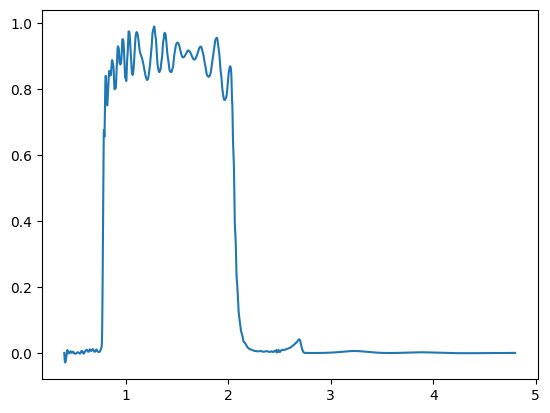

In [28]:
# This class defines a disperser (class is a blueprint for creating an object)
class JWST_disperser:
    def __init__(self, disperser_dict):
        self.resolving_pow = np.array(disperser_dict["R"])
        self.dlds = np.array(disperser_dict["DLDS"])
        self.wavelength = np.array(disperser_dict["WAVELENGTH"])
        self.minwave = min(self.wavelength)
        self.maxwave = max(self.wavelength)

class JWST_filter:
    def __init__(self, filter_dict):
        self.throughput = np.array(filter_dict["THROUGHPUT"])
        self.wavelength = np.array(filter_dict["WAVELENGTH"])
        self.minwave = min(self.wavelength)
        self.maxwave = max(self.wavelength)
    
    # making an interpolator - a funtion that allows to predict values between known data points 
    # We are using cubin interpolation since it smoothens the values between the given data points more flexibly than linear interpolation 
    def inter(self):
        smth_thr = inter.interp1d(self.wavelength, self.throughput, kind = 'cubic')
        return smth_thr
        
f110w = JWST_filter(JWST_fil_dict["f140x"])
interpolated_test = JWST_filter.inter(f110w)
# using linspace, we are creating 2000 evenly spaced values between the minwavelength and maxwavelength of f110w filter 
x = np.linspace(f110w.minwave,f110w.maxwave,2000) 
plt.plot(x, interpolated_test(x))


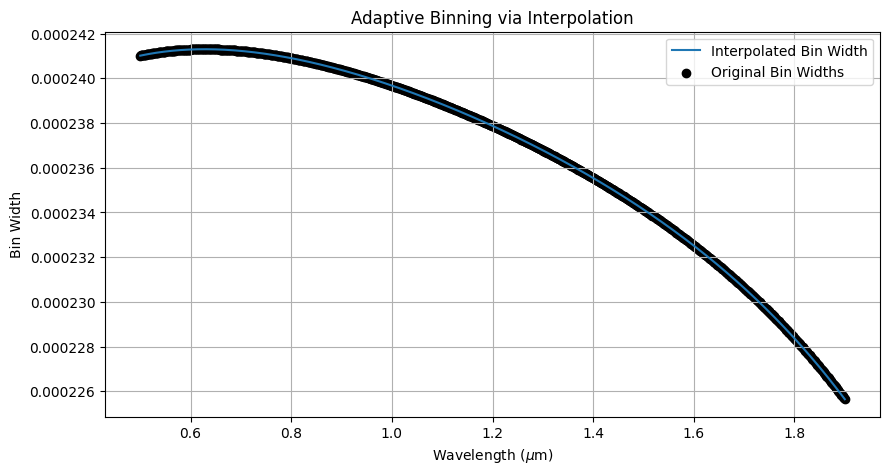

In [ ]:
# Example wavelength range and corresponding bin widths
wavelengths = np.array(JWST_disp_dict["g140h"]["WAVELENGTH"])  # e.g., in _m
bin_widths = np.array(JWST_disp_dict["g140h"]["DLDS"])       # bin width at each wavelength

def edge_finder(wavelengths, bin_widths):
    # Interpolate bin width as a function of wavelength
    interp_bin_width = interp1d(wavelengths, bin_widths, kind='cubic', fill_value="extrapolate")

    # Set start and end of the full wavelength range
    start = 0.5
    end = 1.9

    # Create adaptive bins
    bin_edges = [start]
    current = start

    while current < end:
        width = interp_bin_width(current)
        next_edge = current + width
        if next_edge > end:
            break
        bin_edges.append(next_edge)
        current = next_edge

    # Ensure last bin edge reaches the end
    if bin_edges[-1] < end:
        bin_edges.append(end)

    # Convert bin edges to numpy array
    bin_edges = np.array(bin_edges)
    return bin_edges, start, end, interp_bin_width

bin_edges, start, end, interp_bin_width = edge_finder(wavelengths, bin_widths)



# Plot the interpolated bin width function and the bin edges
x_dense = np.linspace(start, end, 1000)
y_interp = interp_bin_width(x_dense) 

plt.figure(figsize=(10,5))
plt.plot(x_dense, y_interp, label='Interpolated Bin Width')
#plt.vlines(bin_edges, ymin=0, ymax=max(bin_widths), color='red', linestyles='dashed', label='Bin Edges')
plt.scatter(wavelengths, bin_widths, color='black', label='Original Bin Widths')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Bin Width')
#plt.xlim(1.89,1.9)
plt.title('Adaptive Binning via Interpolation')
plt.legend()
plt.grid(True)
plt.show()


# Fits opener

Takes fits files and opens them, need to add functionality to allow for wavelength extraction

Look for the disperser absorption? data

Get sigma from the line spread function for JWST

Send ashiq info on LSF and how we can calculate sigma from it

# Relics

In [5]:
import numpy as np

import matplotlib.pyplot as plt



"""print(df.columns)
binmrk = np.array(df["DLDS"])
binsz = -np.diff(binmrk)
#print(binsz) #this should return the bin size of my 

print(df)

waves = np.array(df["WAVELENGTH"])
binwave = np.zeros(len(waves)-1)
for i in range(len(waves)-1):
    binwave[i] = (waves[i] + waves[i+1])/2

print(binwave)
plt.figure()
plt.plot(binwave, binsz)
plt.ylabel("Bin Size (DLDS)")
plt.xlabel("Wavelength ((mu)m)")
plt.show()"""


'print(df.columns)\nbinmrk = np.array(df["DLDS"])\nbinsz = -np.diff(binmrk)\n#print(binsz) #this should return the bin size of my \n\nprint(df)\n\nwaves = np.array(df["WAVELENGTH"])\nbinwave = np.zeros(len(waves)-1)\nfor i in range(len(waves)-1):\n    binwave[i] = (waves[i] + waves[i+1])/2\n\nprint(binwave)\nplt.figure()\nplt.plot(binwave, binsz)\nplt.ylabel("Bin Size (DLDS)")\nplt.xlabel("Wavelength ((mu)m)")\nplt.show()'